In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import time

In [2]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    'imagenette',
    split=['train[:90%]', 'validation', 'train[90%:]'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
)

In [3]:
ds_train_1 = ds_train.map(lambda image, label: (tf.image.flip_left_right(image), label))
ds_train_2 = ds_train.map(lambda image, label: (tf.image.adjust_brightness(image, 0.3), label))
ds_train_3 = ds_train.map(lambda image, label: (tf.image.adjust_contrast(image, 0.8), label))
ds_train_4 = ds_train.map(lambda image, label: (tf.image.adjust_saturation(image, 0.8), label))
ds_train_5 = ds_train.map(lambda image, label: (tf.image.adjust_hue(image, 0.1), label))
ds_train_6 = ds_train.map(lambda image, label: (tf.image.central_crop(image, 0.9), label))
ds_train_7 = ds_train.map(lambda image, label: (tf.image.adjust_gamma(image, 0.5), label))

ds_train_combined = ds_train.concatenate(ds_train_1).concatenate(ds_train_2).concatenate(ds_train_3).concatenate(ds_train_4).concatenate(ds_train_5).concatenate(ds_train_6).concatenate(ds_train_7)

In [4]:
x_train = ds_train_combined.map(lambda x, y: x)
y_train = ds_train_combined.map(lambda x, y: y)

x_validation = ds_validation.map(lambda x, y: x)
y_validation = ds_validation.map(lambda x, y: y)

x_test = ds_test.map(lambda x, y: x)
y_test = ds_test.map(lambda x, y: y)

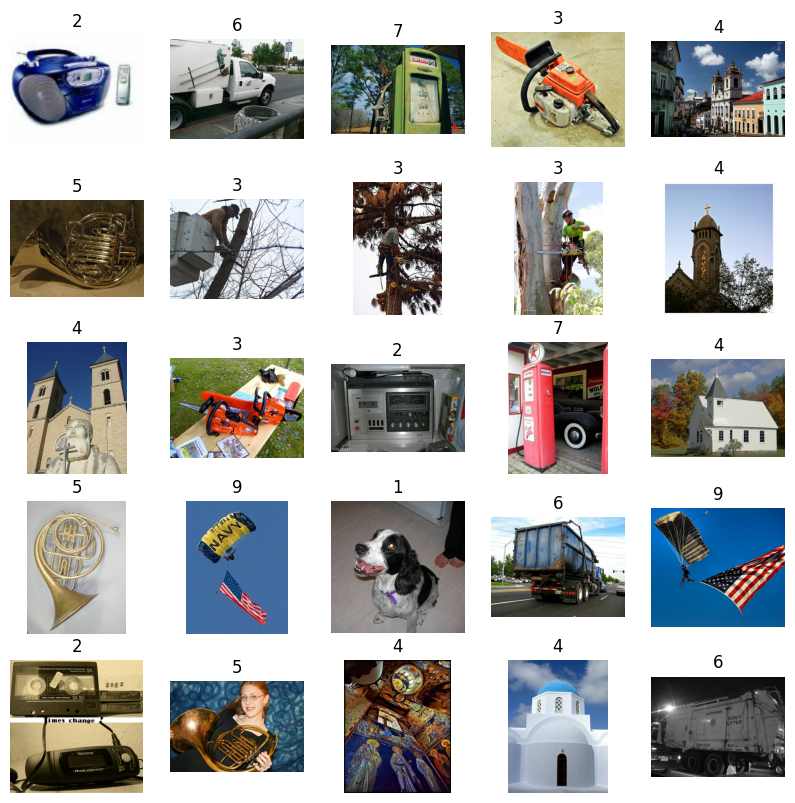

In [5]:
images_iter = iter(x_train)
labels_iter = iter(y_train)
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(next(images_iter).numpy().astype("uint8"))
    plt.title(next(labels_iter).numpy().astype("uint8"))
    plt.axis("off")

In [6]:
def normalize(image):
    image = tf.image.resize(image, (64, 64))
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [-1])
    return image

x_train = x_train.map(normalize)
x_train = np.stack(list(x_train.as_numpy_iterator()), axis=1)

x_validation = x_validation.map(normalize)
x_validation = np.stack(list(x_validation.as_numpy_iterator()), axis=1)

x_test = x_test.map(normalize)
x_test = np.stack(list(x_test.as_numpy_iterator()), axis=1)

In [7]:
def one_hot_encoding(label):
    one_hot = tf.one_hot(label, 10)
    return one_hot

y_train = y_train.map(one_hot_encoding)
y_train = np.stack(list(y_train.as_numpy_iterator()), axis=1)

y_validation = y_validation.map(one_hot_encoding)
y_validation = np.stack(list(y_validation.as_numpy_iterator()), axis=1)

y_test = y_test.map(one_hot_encoding)
y_test = np.stack(list(y_test.as_numpy_iterator()), axis=1)

In [8]:
def initialize_parameters(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

In [9]:
def initialize_adam(parameters):
    L = len(parameters) // 2
    v = {}
    s = {}

    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))

    return v, s

In [10]:
def random_mini_batches(X, Y, mini_batch_size, seed):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []

    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    num_complete_mini_batches = m // mini_batch_size
    for k in range(num_complete_mini_batches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_mini_batches * mini_batch_size :]
        mini_batch_Y = shuffled_Y[:, num_complete_mini_batches * mini_batch_size :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [11]:
def forward_propagation(X, parameters, keep_prob):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    Z1 = np.dot(W1, X) + b1
    A1 = np.maximum(0, Z1)
    D1 = np.random.rand(A1.shape[0], A1.shape[1]) < keep_prob
    A1 = A1 * D1 / keep_prob

    Z2 = np.dot(W2, A1) + b2
    A2 = np.maximum(0, Z2)
    D2 = np.random.rand(A2.shape[0], A2.shape[1]) < keep_prob
    A2 = A2 * D2 / keep_prob
    
    Z3 = np.dot(W3, A2) + b3
    e_Z3 = np.exp(Z3 - np.max(Z3, axis=0, keepdims=True))
    A3 = e_Z3 / (np.sum(e_Z3, axis=0))

    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)

    return A3, cache

In [12]:
def compute_cost(A3, Y, parameters, lambd):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]

    categorical_cross_entropy_cost = -1 * np.sum(Y * np.log(A3))
    L2_regularization_cost = lambd/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    cost = categorical_cross_entropy_cost + L2_regularization_cost

    return cost

In [13]:
def backward_propagation(X, Y, cache, lambd, keep_prob):
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y
    dW3 = 1/m * np.dot(dZ3, A2.T) + (lambd/m) * W3
    db3 = 1/m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dA2 = dA2 * D2 / keep_prob
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1/m * np.dot(dZ2, A1.T) + (lambd/m) * W2
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1 * D1 / keep_prob
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1/m * np.dot(dZ1, X.T) + (lambd/m) * W1
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return grads

In [14]:
def update_parameters(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon):
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}

    for l in range(L):
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)]

        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - beta1**t)

        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1 - beta2) * np.square(grads["dW" + str(l+1)])
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1 - beta2) * np.square(grads["db" + str(l+1)])

        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1 - beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1 - beta2**t)

        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)] / (np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / (np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)

    return parameters

In [15]:
def evaluate(X, Y, parameters):
    m = X.shape[1]
    num_classes = Y.shape[0]
    p = np.zeros((1, m))

    A3, cache = forward_propagation(X, parameters, keep_prob=1)

    p = np.argmax(A3, axis=0)

    accuracy = np.mean(p == np.argmax(Y, axis=0))

    return accuracy

In [16]:
def nn_model(X, Y, layer_dims, learning_rate = 0.0001, mini_batch_size = 64, beta1 = 0.9, beta2 = 0.999, 
          epsilon = 1e-8, num_epochs = 100, lambd = 0, keep_prob = 1, print_cost = True):
    
    costs = []
    val_costs = []
    accuracies = []
    val_accuracies = []
    t = 0
    seed = 10

    # Initialize parameters
    parameters = initialize_parameters(layer_dims)

    # Initialize the optimizer
    v, s = initialize_adam(parameters)

    # Optimization loop
    for i in range(num_epochs):

        # Define mini batches
        start = time.time()
        seed = seed + 1
        mini_batches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0

        # Mini batch loop
        for mini_batch in mini_batches:
            
            # Select a mini_batch
            (mini_batch_X, mini_batch_Y) = mini_batch

            # Forward propagation
            A3, cache = forward_propagation(mini_batch_X, parameters, keep_prob)

            # Compute cost
            cost_total += compute_cost(A3, mini_batch_Y, parameters, lambd)

            # Backward propagation
            grads = backward_propagation(mini_batch_X, mini_batch_Y, cache, lambd, keep_prob)

            # Update parameters
            t += 1
            parameters = update_parameters(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
        
        cost_avg = cost_total / X.shape[1]
        A3, cache = forward_propagation(x_validation, parameters, keep_prob=1)
        val_cost = compute_cost(A3, y_validation, parameters, lambd=0) / x_validation.shape[1]
        accuracy = evaluate(X, Y, parameters)
        val_accuracy = evaluate(x_validation, y_validation, parameters)
        end = time.time()
        run_time = end - start

        # Print cost after every epoch
        if print_cost:
            costs.append(cost_avg)
            val_costs.append(val_cost)
            accuracies.append(accuracy)
            val_accuracies.append(val_accuracy)
            print(f"Epoch {i+1}/{num_epochs}")
            print(f"{int(run_time)}s", end=" ")
            print(f"- loss: {cost_avg:.4f}", end=" ")
            print(f"- accuracy: {accuracy:.2%}", end=" ")
            print(f"- val_loss: {val_cost:.4f}", end=" ")
            print(f"- val_accuracy: {val_accuracy:.2%}")

    # Plot the cost
    plt.plot(np.arange(1, num_epochs+1, 1), costs, label="train")
    plt.plot(np.arange(1, num_epochs+1, 1), val_costs, label="validation")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.plot(np.arange(1, num_epochs+1, 1), accuracies, label="train")
    plt.plot(np.arange(1, num_epochs+1, 1), val_accuracies, label="validation")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    return parameters

Sample 1
learning rate: 0.0318 - dim 1: 78 - dim 2: 64
Sample 2
learning rate: 0.0012 - dim 1: 70 - dim 2: 88
Sample 3
learning rate: 0.0165 - dim 1: 72 - dim 2: 60
Sample 4
learning rate: 0.0146 - dim 1: 85 - dim 2: 89
Sample 5
learning rate: 0.0015 - dim 1: 71 - dim 2: 51
Sample 6
learning rate: 0.0013 - dim 1: 79 - dim 2: 87
Sample 7
learning rate: 0.9929 - dim 1: 70 - dim 2: 82
Sample 8
learning rate: 0.0607 - dim 1: 71 - dim 2: 93
Sample 9
learning rate: 0.8086 - dim 1: 76 - dim 2: 91
Sample 10
learning rate: 0.6506 - dim 1: 65 - dim 2: 64
Sample 11
learning rate: 0.0150 - dim 1: 96 - dim 2: 100
Sample 12
learning rate: 0.0295 - dim 1: 52 - dim 2: 86
Sample 13
learning rate: 0.0037 - dim 1: 70 - dim 2: 58
Sample 14
learning rate: 0.5493 - dim 1: 53 - dim 2: 74
Sample 15
learning rate: 0.0001 - dim 1: 99 - dim 2: 58
Sample 16
learning rate: 0.8632 - dim 1: 51 - dim 2: 69
Sample 17
learning rate: 0.1086 - dim 1: 56 - dim 2: 93
Sample 18
learning rate: 0.0105 - dim 1: 96 - dim 2: 84


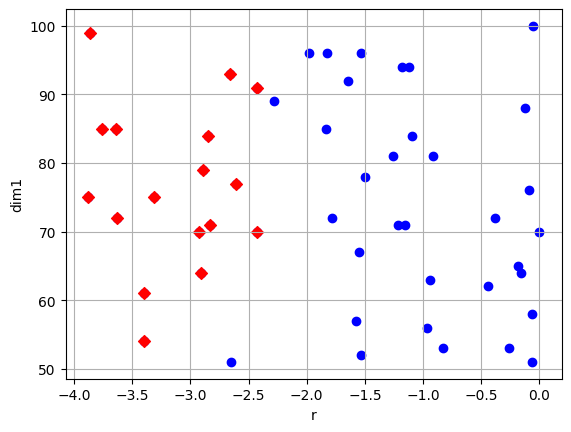

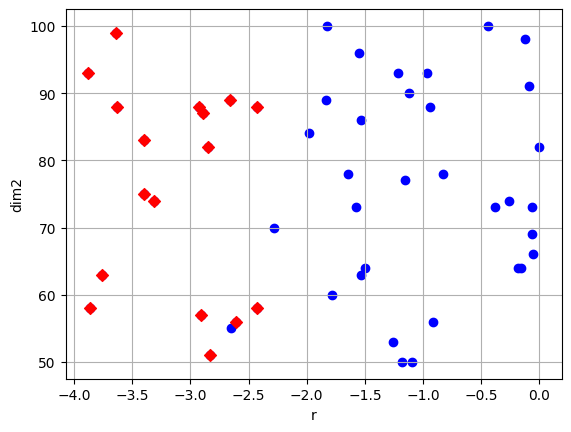

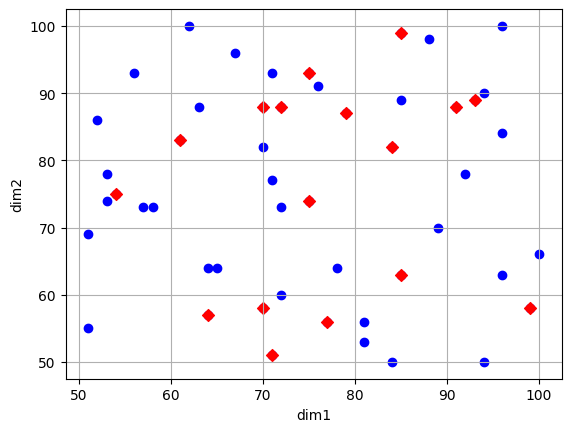

In [17]:
np.random.seed(42)

r_values = []
dim1_values = []
dim2_values = []

for i in range(50):
    r = -4 * np.random.rand()
    learning_rate = 10**r
    dim1 = np.random.randint(50, 101)
    dim2 = np.random.randint(50, 101)

    r_values.append(r)
    dim1_values.append(dim1)
    dim2_values.append(dim2)

    print(f"Sample {i+1}")
    print(f"learning rate: {learning_rate:.4f} - dim 1: {dim1} - dim 2: {dim2}")

marked_indices = [1, 4, 5, 12, 14, 18, 21, 22, 23, 26, 32, 33, 34, 35, 37, 40, 46]  # Sample value - 1

plt.figure(1)
plt.scatter(r_values, dim1_values, c='blue')
plt.scatter(np.array(r_values)[marked_indices], np.array(dim1_values)[marked_indices],
            c='red', marker='D')
plt.xlabel('r')
plt.ylabel('dim1')
plt.grid(True)

plt.figure(2)
plt.scatter(r_values, dim2_values, c='blue')
plt.scatter(np.array(r_values)[marked_indices], np.array(dim2_values)[marked_indices],
            c='red', marker='D')
plt.xlabel('r')
plt.ylabel('dim2')
plt.grid(True)

plt.figure(3)
plt.scatter(dim1_values, dim2_values, c='blue')
plt.scatter(np.array(dim1_values)[marked_indices], np.array(dim2_values)[marked_indices],
            c='red', marker='D')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.grid(True)

plt.show()

Sample 1
learning rate: 0.0004 - dim 1: 78 - dim 2: 64
Sample 2
learning rate: 0.0014 - dim 1: 70 - dim 2: 88
Sample 3
learning rate: 0.0005 - dim 1: 72 - dim 2: 60
Sample 4
learning rate: 0.0005 - dim 1: 85 - dim 2: 89
Sample 5
learning rate: 0.0013 - dim 1: 71 - dim 2: 51
Sample 6
learning rate: 0.0014 - dim 1: 79 - dim 2: 87
Sample 7
learning rate: 0.0001 - dim 1: 70 - dim 2: 82
Sample 8
learning rate: 0.0003 - dim 1: 71 - dim 2: 93
Sample 9
learning rate: 0.0001 - dim 1: 76 - dim 2: 91
Sample 10
learning rate: 0.0001 - dim 1: 65 - dim 2: 64
Sample 11
learning rate: 0.0005 - dim 1: 96 - dim 2: 100
Sample 12
learning rate: 0.0004 - dim 1: 52 - dim 2: 86
Sample 13
learning rate: 0.0009 - dim 1: 70 - dim 2: 58
Sample 14
learning rate: 0.0001 - dim 1: 53 - dim 2: 74
Sample 15
learning rate: 0.0034 - dim 1: 99 - dim 2: 58
Sample 16
learning rate: 0.0001 - dim 1: 51 - dim 2: 69
Sample 17
learning rate: 0.0002 - dim 1: 56 - dim 2: 93
Sample 18
learning rate: 0.0006 - dim 1: 96 - dim 2: 84


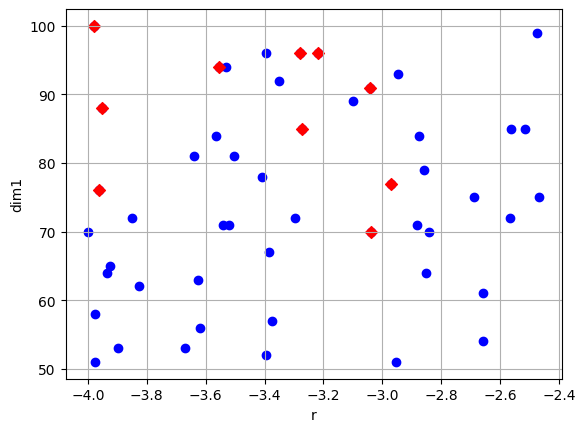

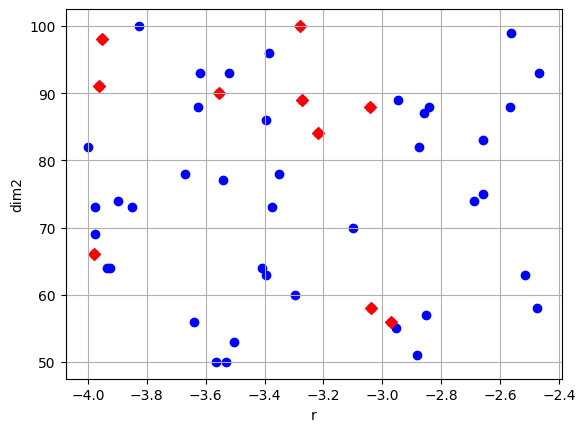

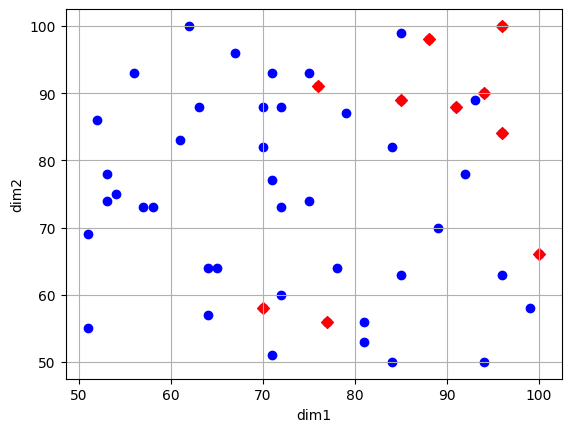

In [98]:
np.random.seed(42)

r_values = []
dim1_values = []
dim2_values = []

for i in range(50):
    r = np.random.uniform(-4, -2.42)
    learning_rate = 10**r
    dim1 = np.random.randint(50, 101)
    dim2 = np.random.randint(50, 101)

    r_values.append(r)
    dim1_values.append(dim1)
    dim2_values.append(dim2)

    print(f"Sample {i+1}")
    print(f"learning rate: {learning_rate:.4f} - dim 1: {dim1} - dim 2: {dim2}")

marked_indices = [44, 3, 8, 10, 12, 17, 27, 31, 33, 34]  # Sample value - 1

plt.figure(1)
plt.scatter(r_values, dim1_values, c='blue')
plt.scatter(np.array(r_values)[marked_indices], np.array(dim1_values)[marked_indices], c='red', marker='D')
plt.xlabel('r')
plt.ylabel('dim1')
plt.grid(True)

plt.figure(2)
plt.scatter(r_values, dim2_values, c='blue')
plt.scatter(np.array(r_values)[marked_indices], np.array(dim2_values)[marked_indices], c='red', marker='D')
plt.xlabel('r')
plt.ylabel('dim2')
plt.grid(True)

plt.figure(3)
plt.scatter(dim1_values, dim2_values, c='blue')
plt.scatter(np.array(dim1_values)[marked_indices], np.array(dim2_values)[marked_indices], c='red', marker='D')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.grid(True)

plt.show()

Sample 1
learning rate: 0.0006 - dim 1: 95 - dim 2: 81
Sample 2
learning rate: 0.0003 - dim 1: 97 - dim 2: 85
Sample 3
learning rate: 0.0001 - dim 1: 98 - dim 2: 86
Sample 4
learning rate: 0.0004 - dim 1: 100 - dim 2: 96
Sample 5
learning rate: 0.0001 - dim 1: 99 - dim 2: 91
Sample 6
learning rate: 0.0002 - dim 1: 89 - dim 2: 93
Sample 7
learning rate: 0.0002 - dim 1: 94 - dim 2: 99
Sample 8
learning rate: 0.0009 - dim 1: 88 - dim 2: 92
Sample 9
learning rate: 0.0002 - dim 1: 100 - dim 2: 95
Sample 10
learning rate: 0.0003 - dim 1: 96 - dim 2: 84
Sample 11
learning rate: 0.0004 - dim 1: 92 - dim 2: 100
Sample 12
learning rate: 0.0004 - dim 1: 90 - dim 2: 89
Sample 13
learning rate: 0.0001 - dim 1: 97 - dim 2: 99
Sample 14
learning rate: 0.0009 - dim 1: 95 - dim 2: 90
Sample 15
learning rate: 0.0006 - dim 1: 89 - dim 2: 95
Sample 16
learning rate: 0.0004 - dim 1: 99 - dim 2: 87
Sample 17
learning rate: 0.0001 - dim 1: 89 - dim 2: 87
Sample 18
learning rate: 0.0001 - dim 1: 85 - dim 2: 9

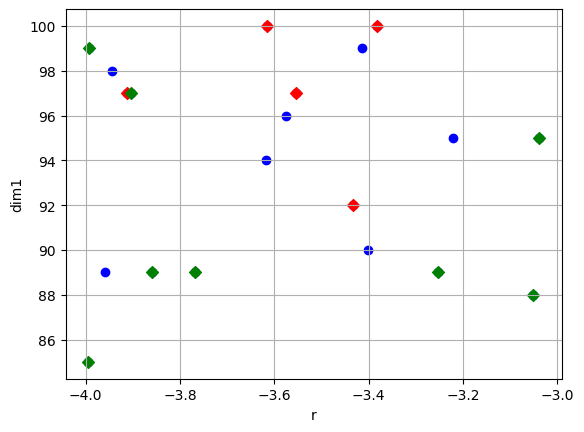

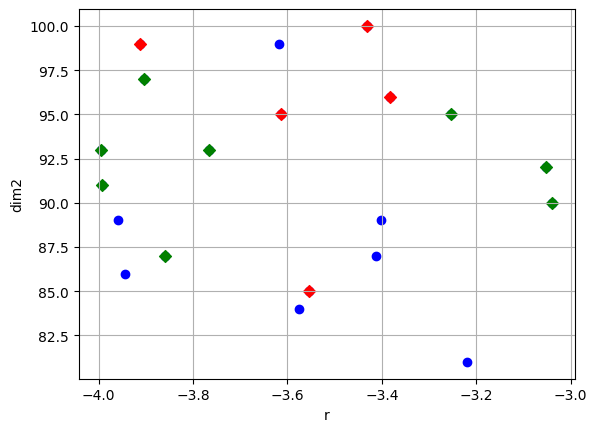

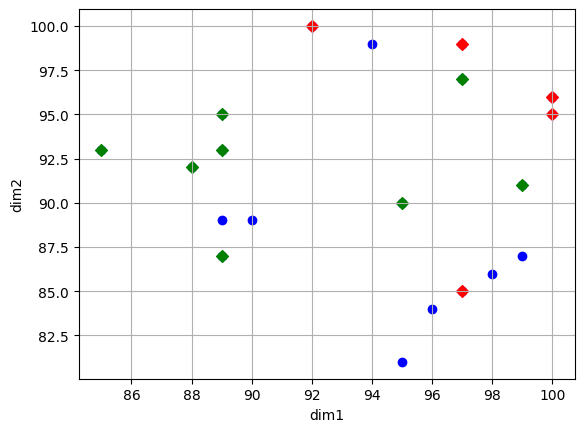

In [18]:
np.random.seed(42)

r_values = []
dim1_values = []
dim2_values = []

i = 0
while i < 20:
    r = np.random.uniform(-4, -3)
    learning_rate = 10**r
    dim1 = np.random.randint(75, 101)
    dim2 = np.random.randint(75, 101)
    
    if dim1 + dim2 <= 175:
        continue

    r_values.append(r)
    dim1_values.append(dim1)
    dim2_values.append(dim2)
    i += 1

    print(f"Sample {i}")
    print(f"learning rate: {learning_rate:.4f} - dim 1: {dim1} - dim 2: {dim2}")

marked_indices = [1, 3, 8, 10, 12]
bad = [18, 5, 4, 7, 13, 14, 17, 16]

plt.figure(1)
plt.scatter(r_values, dim1_values, c='blue')
plt.scatter(np.array(r_values)[marked_indices], np.array(dim1_values)[marked_indices], c='red', marker='D')
plt.scatter(np.array(r_values)[bad], np.array(dim1_values)[bad], c='green', marker='D')
plt.xlabel('r')
plt.ylabel('dim1')
plt.grid(True)

plt.figure(2)
plt.scatter(r_values, dim2_values, c='blue')
plt.scatter(np.array(r_values)[marked_indices], np.array(dim2_values)[marked_indices], c='red', marker='D')
plt.scatter(np.array(r_values)[bad], np.array(dim2_values)[bad], c='green', marker='D')
plt.xlabel('r')
plt.ylabel('dim2')
plt.grid(True)

plt.figure(3)
plt.scatter(dim1_values, dim2_values, c='blue')
plt.scatter(np.array(dim1_values)[marked_indices], np.array(dim2_values)[marked_indices], c='red', marker='D')
plt.scatter(np.array(dim1_values)[bad], np.array(dim2_values)[bad], c='green', marker='D')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.grid(True)

plt.show()

Sample 1
learning rate: 0.0006 - dim 1: 95 - dim 2: 81
Sample 2
learning rate: 0.0003 - dim 1: 97 - dim 2: 85
Sample 3
learning rate: 0.0001 - dim 1: 98 - dim 2: 86
Sample 4
learning rate: 0.0004 - dim 1: 100 - dim 2: 96
Sample 5
learning rate: 0.0001 - dim 1: 99 - dim 2: 91
Sample 6
learning rate: 0.0002 - dim 1: 89 - dim 2: 93
Sample 7
learning rate: 0.0002 - dim 1: 94 - dim 2: 99
Sample 8
learning rate: 0.0009 - dim 1: 88 - dim 2: 92
Sample 9
learning rate: 0.0002 - dim 1: 100 - dim 2: 95
Sample 10
learning rate: 0.0003 - dim 1: 96 - dim 2: 84
Sample 11
learning rate: 0.0004 - dim 1: 92 - dim 2: 100
Sample 12
learning rate: 0.0004 - dim 1: 90 - dim 2: 89
Sample 13
learning rate: 0.0001 - dim 1: 97 - dim 2: 99
Sample 14
learning rate: 0.0009 - dim 1: 95 - dim 2: 90
Sample 15
learning rate: 0.0006 - dim 1: 89 - dim 2: 95
Sample 16
learning rate: 0.0004 - dim 1: 99 - dim 2: 87
Sample 17
learning rate: 0.0001 - dim 1: 89 - dim 2: 87
Sample 18
learning rate: 0.0001 - dim 1: 85 - dim 2: 9

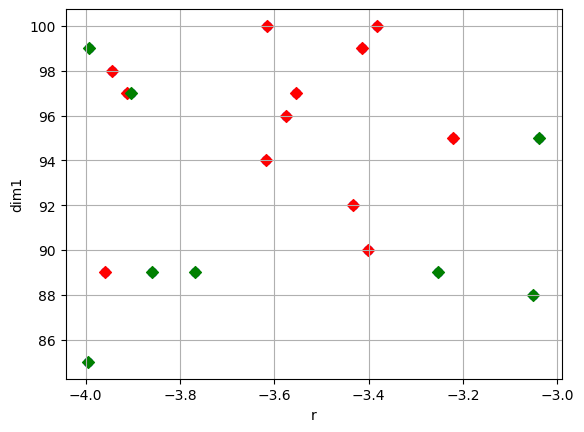

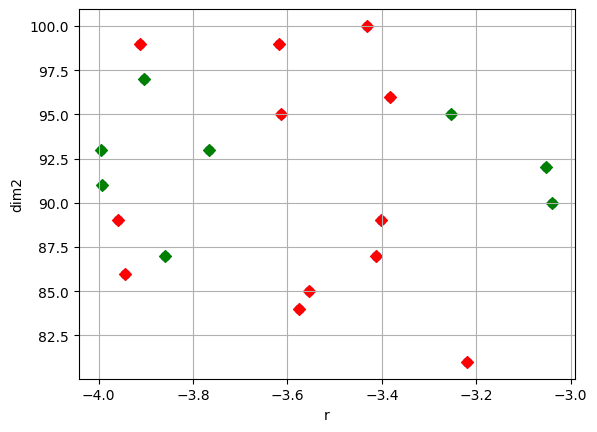

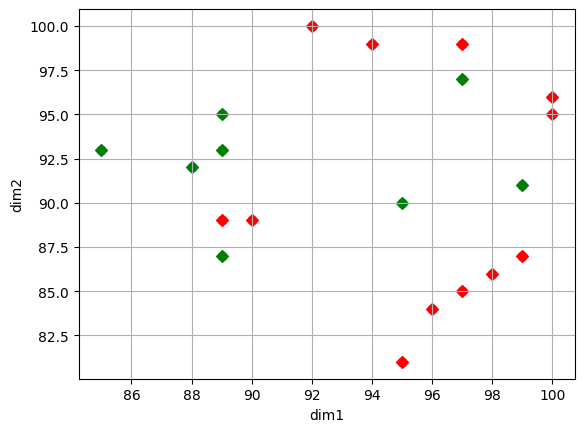

In [5]:
np.random.seed(42)

r_values = []
dim1_values = []
dim2_values = []

i = 0
while i < 20:
    r = np.random.uniform(-4, -3)
    learning_rate = 10**r
    dim1 = np.random.randint(75, 101)
    dim2 = np.random.randint(75, 101)
    
    if dim1 + dim2 <= 175:
        continue

    r_values.append(r)
    dim1_values.append(dim1)
    dim2_values.append(dim2)
    i += 1

    print(f"Sample {i}")
    print(f"learning rate: {learning_rate:.4f} - dim 1: {dim1} - dim 2: {dim2}")

marked_indices = [1, 3, 8, 10, 12, 0, 2, 6, 9, 11, 15, 19]
bad = [18, 5, 4, 7, 13, 14, 17, 16]

plt.figure(1)
plt.scatter(r_values, dim1_values, c='blue')
plt.scatter(np.array(r_values)[marked_indices], np.array(dim1_values)[marked_indices], c='red', marker='D')
plt.scatter(np.array(r_values)[bad], np.array(dim1_values)[bad], c='green', marker='D')
plt.xlabel('r')
plt.ylabel('dim1')
plt.grid(True)

plt.figure(2)
plt.scatter(r_values, dim2_values, c='blue')
plt.scatter(np.array(r_values)[marked_indices], np.array(dim2_values)[marked_indices], c='red', marker='D')
plt.scatter(np.array(r_values)[bad], np.array(dim2_values)[bad], c='green', marker='D')
plt.xlabel('r')
plt.ylabel('dim2')
plt.grid(True)

plt.figure(3)
plt.scatter(dim1_values, dim2_values, c='blue')
plt.scatter(np.array(dim1_values)[marked_indices], np.array(dim2_values)[marked_indices], c='red', marker='D')
plt.scatter(np.array(dim1_values)[bad], np.array(dim2_values)[bad], c='green', marker='D')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.grid(True)

plt.show()

Epoch 1/200
244s - loss: 1.9846 - accuracy: 36.04% - val_loss: 1.8776 - val_accuracy: 36.15%
Epoch 2/200
207s - loss: 1.7905 - accuracy: 41.70% - val_loss: 1.8038 - val_accuracy: 38.45%
Epoch 3/200
217s - loss: 1.7076 - accuracy: 44.17% - val_loss: 1.7731 - val_accuracy: 39.97%
Epoch 4/200
218s - loss: 1.6409 - accuracy: 47.33% - val_loss: 1.7449 - val_accuracy: 41.81%
Epoch 5/200
195s - loss: 1.6010 - accuracy: 45.55% - val_loss: 1.7721 - val_accuracy: 41.02%
Epoch 6/200
199s - loss: 1.5447 - accuracy: 50.31% - val_loss: 1.7356 - val_accuracy: 41.91%
Epoch 7/200
167s - loss: 1.5005 - accuracy: 46.73% - val_loss: 1.8102 - val_accuracy: 39.06%
Epoch 8/200
180s - loss: 1.4582 - accuracy: 53.42% - val_loss: 1.7422 - val_accuracy: 42.22%
Epoch 9/200
176s - loss: 1.4220 - accuracy: 51.33% - val_loss: 1.7846 - val_accuracy: 41.25%
Epoch 10/200
175s - loss: 1.3761 - accuracy: 54.18% - val_loss: 1.7618 - val_accuracy: 41.35%
Epoch 11/200
176s - loss: 1.3300 - accuracy: 52.34% - val_loss: 1.826

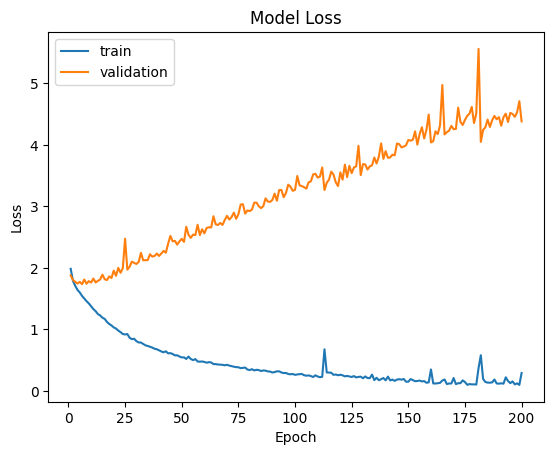

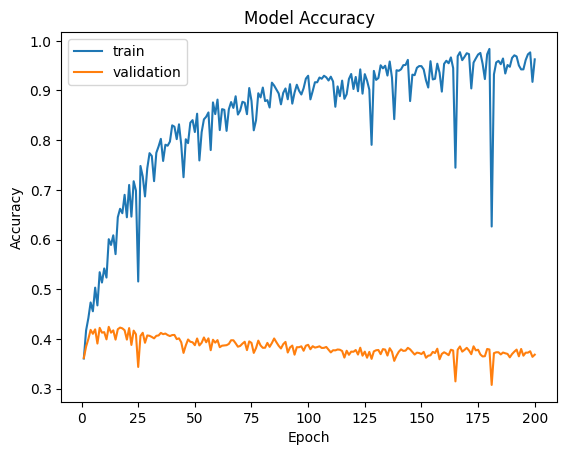

In [19]:
parameters =  nn_model(x_train, y_train, [x_train.shape[0], 100, 100, 10], learning_rate = 0.0003, mini_batch_size = 512, beta1 = 0.9, beta2 = 0.999, 
          epsilon = 1e-8, num_epochs = 200, lambd = 0, keep_prob = 1, print_cost = True)

In [21]:
import pickle

with open('trained_parameters.pkl', 'wb') as f:
    pickle.dump(parameters, f)

In [22]:
evaluate(x_test, y_test, parameters)

0.3759239704329461